# Calcul des jours Tempos

Voir : [la doc](https://www.services-rte.com/files/live/sites/services-rte/files/pdf/20160106_Methode_de_choix_des_jours_Tempo.pdf
)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from energy_forecast import ROOT_DIR
from energy_forecast.tempo_rte import TempoPredictor

In [43]:
data_file = ROOT_DIR / "data/rte_agg_daily_2014_2024.csv"
data_agg = pd.read_csv(data_file, index_col=0, parse_dates=True)
data_agg.index = pd.to_datetime(data_agg.index)

In [44]:
data_agg.head()

,Type_de_jour_TEMPO,Consommation,Prévision_J-1,Prévision_J,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,Pompage,Bioénergies,Ech_physiques,Taux_de_Co2,Ech_comm,sun,wind
Date,,,,,,,,,,,,,,,,,,
2015-01-01,BLANC,1613817.0,1569650.0,1603950.0,7666.5,28191.5,56216.0,1388930.5,51127.0,11370.5,158136.5,-26906.5,21712.5,-82623.5,1028.0,-76107.0,NaN,NaN
2015-01-02,BLANC,1656045.5,1672200.0,1643050.0,7796.5,43440.5,62653.5,1400287.0,78933.0,8297.5,180503.0,-17687.5,21602.5,-129775.5,1196.0,-121458.0,NaN,NaN
2015-01-03,BLEU,1538261.0,1543750.0,1528950.0,7723.0,34074.0,54482.0,1376450.5,105299.0,5860.5,141242.5,-32067.0,21850.0,-176653.5,1086.0,-168566.0,NaN,NaN
2015-01-04,BLEU,1413088.0,1436800.0,1407550.0,7713.5,29848.0,54893.5,1328030.0,30061.0,6926.0,145347.5,-43888.0,21477.0,-167324.0,1112.5,-158445.0,NaN,NaN
2015-01-05,ROUGE,1710599.5,1670450.0,1694950.0,8009.0,63351.5,121532.0,1395291.0,16004.0,9786.5,209115.5,-19182.5,20816.5,-114123.5,1668.0,-105154.0,NaN,NaN


In [58]:
used_cols = ["Prévision_J-1", "Type_de_jour_TEMPO", "Eolien", "Solaire"]
data: pd.DataFrame = data_agg.loc["2022-09-01":"2023-08-31", used_cols]  # type: ignore
predictor = TempoPredictor(data)
predictions = predictor.predict()
predictor.confusion_matrix(data_pred=predictions)

col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,19,1,23
BLEU,91,208,1
ROUGE,0,0,22


## Now using Forecasted production

The RTE classification is done the day before, based on the forecasted production. We will use the same data to classify the days.

In [54]:
data_forecast_file = ROOT_DIR / "data/silver/forecasted_production.csv"
data_forecast = pd.read_csv(data_forecast_file, index_col=0)
data_forecast.index = pd.to_datetime(data_forecast.index, utc=True).tz_localize(None)  # type: ignore
# resample to daily from 6am to 6am
daily_forecast = data_forecast.resample("D", origin="06:00:00").sum()

daily_forecast.index = daily_forecast.index - pd.Timedelta(hours=6)  # type: ignore
daily_forecast.head()

,FORECAST_D1_SOLAR,FORECAST_D1_EOLIEN
start_date,,
2022-02-01,0.00,53922.45
2022-02-02,25611.40,101260.82
2022-02-03,26034.16,73235.63
2022-02-04,19710.59,159568.08
2022-02-05,30702.25,175855.14


In [56]:
used_cols = ["Prévision_J-1", "Type_de_jour_TEMPO"]
all_data = pd.concat([data_agg[used_cols], daily_forecast], axis=1).dropna()
all_data.rename(
    columns={"FORECAST_D1_SOLAR": "Solaire", "FORECAST_D1_EOLIEN": "Eolien"},
    inplace=True,
)
period_start = all_data.index[0] + pd.DateOffset(day=1, month=9)
period_end = period_start + pd.DateOffset(years=1, days=-1)
print(period_start, period_end)
all_data = all_data.loc[period_start:period_end]
all_data

2022-09-01 00:00:00 2023-08-31 00:00:00


,Prévision_J-1,Type_de_jour_TEMPO,Solaire,Eolien
2022-09-01,1106650.0,BLEU,68375.04,42995.35
2022-09-02,1081925.0,BLEU,50872.25,43115.24
2022-09-03,945125.0,BLEU,56447.35,46623.69
2022-09-04,903875.0,BLEU,71938.19,66545.15
2022-09-05,1075950.0,BLEU,68783.20,66041.44
...,...,...,...,...
2023-08-27,878250.0,BLEU,69547.21,99322.30
2023-08-28,987675.0,BLEU,70295.54,84276.31
2023-08-29,1013650.0,BLEU,80138.51,58030.63
2023-08-30,1031375.0,BLEU,86203.59,93396.01


In [104]:
predictor = TempoPredictor(all_data)
predictions = predictor.predict()
predictor.confusion_matrix(data_pred=predictions)

col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,34,1,8
BLEU,11,289,0
ROUGE,1,0,21


In [105]:
import matplotlib.pyplot as plt
import numpy as np

In [106]:
predictor.categories["ROUGE"]

2022-09-01    0
2022-09-02    0
2022-09-03    0
2022-09-04    0
2022-09-05    0
             ..
2023-08-27    0
2023-08-28    0
2023-08-29    0
2023-08-30    0
2023-08-31    0
Freq: D, Name: ROUGE, Length: 365, dtype: int64

Text(0.5, 1.0, 'Production normée et seuils de déclenchement des couleurs Tempo')

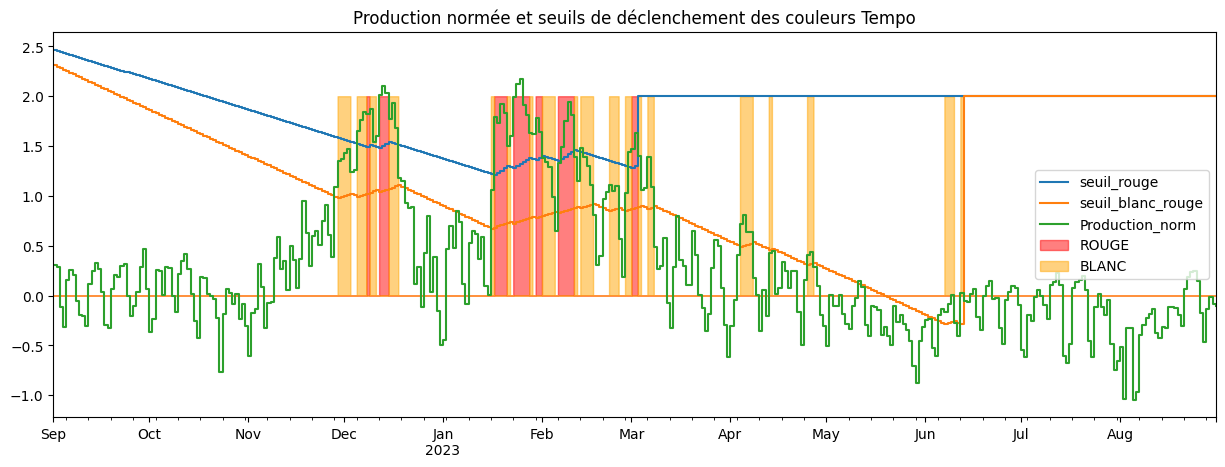

In [107]:
ax = predictor.data[["seuil_rouge", "seuil_blanc_rouge", "Production_norm"]].plot(
    drawstyle="steps-post", figsize=(15, 5)
)

xs = np.arange(ax.dataLim.min[0], ax.dataLim.max[0] + 1, 1)
ax.fill_between(
    xs,
    predictor.categories["ROUGE"].values * 2,
    step="post",
    color="red",
    alpha=0.5,
    label="ROUGE",
)
# predictor.categories["ROUGE"].plot(ax=ax, style="-", color="red", drawstyle="steps-post")
ax.fill_between(
    xs,
    predictor.categories["BLANC"].values * 2,
    step="post",
    color="orange",
    alpha=0.5,
    label="BLANC",
)
# predictor.categories["BLANC"].plot(ax=ax, style="-", color="orange", drawstyle="steps-post")
ax.legend()
ax.set_title("Production normée et seuils de déclenchement des couleurs Tempo")

Text(0.5, 1.0, 'Production normée et seuils de déclenchement des couleurs Tempo')

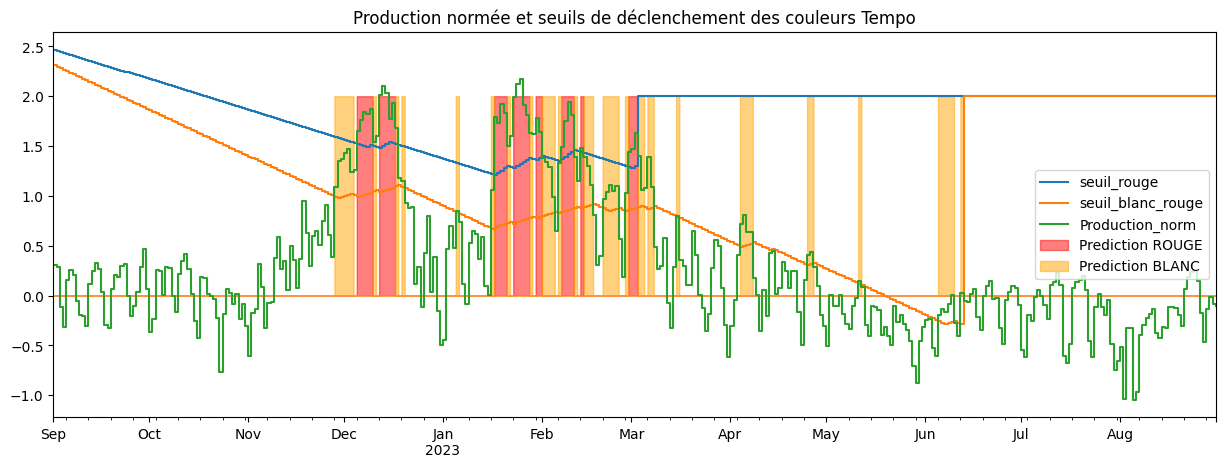

In [109]:
predictions = predictor.predict()
predictions["prediction_rouge"].astype(int).plot(
    ax=ax, style="-", color="red", drawstyle="steps-post"
)
predictions["prediction_blanc"].astype(int).plot(
    ax=ax, style="-", color="orange", drawstyle="steps-post"
)

ax = predictor.data[["seuil_rouge", "seuil_blanc_rouge", "Production_norm"]].plot(
    drawstyle="steps-post", figsize=(15, 5)
)

xs = np.arange(ax.dataLim.min[0], ax.dataLim.max[0] + 1, 1)
ax.fill_between(
    xs,
    predictions["prediction_rouge"].values * 2,
    step="post",
    color="red",
    alpha=0.5,
    label="Prediction ROUGE",
)
# predictor.categories["ROUGE"].plot(ax=ax, style="-", color="red", drawstyle="steps-post")
ax.fill_between(
    xs,
    predictions["prediction_blanc"].values * 2,
    step="post",
    color="orange",
    alpha=0.5,
    label="Prediction BLANC",
)
# predictor.categories["BLANC"].plot(ax=ax, style="-", color="orange", drawstyle="steps-post")
ax.legend()
ax.set_title("Production normée et seuils de déclenchement des couleurs Tempo")